# Prediction of marketing success
### Zora Schärer

## Problem Definition
The starbucks data contains information about customers, about different types of offers made to these customers and about the purchase behaviour of the customers after they received these offers. From a marketing perspective it is interesting to know if is worth sending offers to certain customers.

In order to solve this problem this project takes two steps:
1. A classification model is trained to predict the outcome of an offer depending on features regarding user demographics as well as offer characteristics.
2. This model is used to predict the oucome of each offer in the offer portfolio for any new or existing user. 

The result of the project can be seen as a marketing tool to decide what kind of offers to send to users.

## Libraries & Data

In [1]:
# read libraries
# general
import pandas as pd
import numpy as np
import json
import math
import time
from datetime import date
import pickle

# plotting
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# read data
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data exploration and cleaning

### Portfolio dataframe

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


Before further exploration of this dataframe, the `channels` column needs to be separated into 4 columns with 0 or 1 entries.

In [4]:
# create a dataframe with 0 and 1 entries for each channel type
channel_df = pd.DataFrame(index = portfolio.index, columns = ['email', 'mobile', 'social', 'web'])
for index, row in portfolio.iterrows():
    for i in range(len(row.channels)):
        channel_df[row.channels[i]].loc[index] = 1
channel_df.fillna(0, inplace = True)

In [5]:
# concatenate the channel_df with the portfolio dataframe
portfolio = pd.concat([portfolio, channel_df], axis = 1).drop(columns=['channels'])

In [6]:
# rename id to offer_id
portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)

In [7]:
portfolio.dtypes

reward         int64
difficulty     int64
duration       int64
offer_type    object
offer_id      object
email          int64
mobile         int64
social         int64
web            int64
dtype: object

In [8]:
portfolio.shape

(10, 9)

In [9]:
portfolio.isna().sum()

reward        0
difficulty    0
duration      0
offer_type    0
offer_id      0
email         0
mobile        0
social        0
web           0
dtype: int64

In [10]:
portfolio.describe()

,reward,difficulty,duration,email,mobile,social,web
count,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000,1.0,0.900000,0.600000,0.800000
std,3.583915,5.831905,2.321398,0.0,0.316228,0.516398,0.421637
min,0.000000,0.000000,3.000000,1.0,0.000000,0.000000,0.000000
25%,2.000000,5.000000,5.000000,1.0,1.000000,0.000000,1.000000
50%,4.000000,8.500000,7.000000,1.0,1.000000,1.000000,1.000000
75%,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000
max,10.000000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000


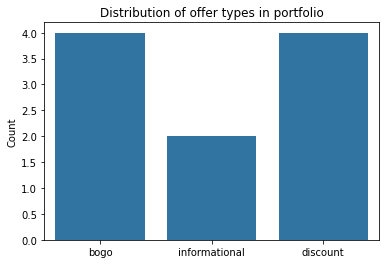

In [11]:
col = sb.color_palette()[0]
sb.countplot(data = portfolio, x  = 'offer_type', color = col)
plt.xlabel('')
plt.ylabel('Count')
plt.title('Distribution of offer types in portfolio');

In [12]:
# save portfolio data frame for further use
portfolio.to_csv('data/portfolio.csv', index = False)

### Profile dataframe

In [13]:
profile.sample(10)

,gender,age,id,became_member_on,income
3859,M,48,bc9967a6750e496ab469784ce225ade2,20160104,72000.0
11817,F,69,9b8d563583b94b4885871a509cfd7a49,20171104,79000.0
9257,M,89,b350ab04dcd3426c8d3159af7d44a2de,20150113,74000.0
3136,M,19,43c18a0cc9fc4e02bbc1bedd52c7859b,20170911,37000.0
9445,None,118,0c568217dc7d47ca936b567f8a22588f,20180516,NaN
9403,F,40,24bfa125f2ba493f9b5f7abacc83f796,20160731,58000.0
1664,M,76,738410e6d6044fbca05d6dad73bd6382,20170703,76000.0
3999,M,51,2210c471e13e49539d624a8f2b04f682,20170807,81000.0
16603,M,52,62f82083cfb64929bfb7e6d91bd178e3,20130818,94000.0
3041,M,31,f07b9bb0e6d64cc9b47c4638b543179a,20180407,58000.0


In [14]:
profile.rename(columns = {'id': 'user_id'}, inplace = True)

In [15]:
profile.dtypes

gender               object
age                   int64
user_id              object
became_member_on      int64
income              float64
dtype: object

In [16]:
# change datatype of became_member_on column
profile['became_member_on'] = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

In [17]:
profile.shape

(17000, 5)

In [18]:
profile.isna().sum()

gender              2175
age                    0
user_id                0
became_member_on       0
income              2175
dtype: int64

In [19]:
# check occurence of NaN values
profile[profile.gender.isna()]

,gender,age,user_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,2016-09-01,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,2016-04-15,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,2018-03-05,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,2016-01-16,NaN


In [20]:
# since there is practically no information on these users, they will be dropped
profile.dropna(axis = 0, inplace = True)

In [21]:
profile.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


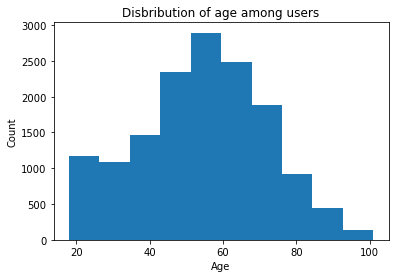

In [22]:
plt.hist(profile.age)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Disbribution of age among users');

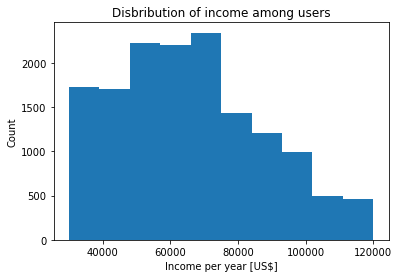

In [23]:
plt.hist(profile.income)
plt.xlabel('Income per year [US$]')
plt.ylabel('Count')
plt.title('Disbribution of income among users');

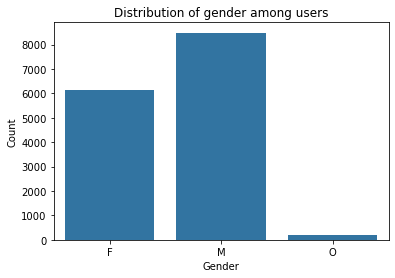

In [24]:
sb.countplot(data = profile, x  = 'gender', color = col)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of gender among users');

### Transcript dataframe

In [25]:
transcript.sample(10)

,person,event,value,time
29199,f3dfe66c8d74446189b21c7c704f2182,transaction,{'amount': 19.0},42
70498,9a47a77eb8fc43dc8c65ddfdee1123ee,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},174
46295,547b2f119694435b9f3ecd92867468dc,transaction,{'amount': 2.51},120
37898,625d12f6c0ff481ca23ebefddd0e8d0a,transaction,{'amount': 6.53},78
15243,227f7c7fcd3f445691431763078d39b1,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
48762,a33e1e7f26ea4b9a824bf1902ee073fc,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},138
113139,96fbfcfa100443c3994aa3bcda55069e,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336
221037,1c8cf4af93464dcaa971cfcffc2cc1e5,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},510
268797,6c8d485e29df40bd984bc04dda96faf0,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},588
81181,3193b8e2bafd48859069d1ec891ff92a,offer completed,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,198


Before further exploration of this dataframe, the `value` column needs to be separated into 2 columns for amount and offer id. 

In [26]:
extended_value = pd.json_normalize(transcript.value)

In [27]:
transcript['offer_received'] = extended_value['offer id']
transcript['offer_viewed'] = extended_value['offer id']
transcript['offer_completed'] = extended_value['offer_id']
transcript['transaction'] = extended_value['amount']
transcript['reward'] = extended_value['reward']

In [28]:
transcript.loc[transcript.event == 'offer received', 'offer_viewed'] = np.nan
transcript.loc[transcript.event == 'offer viewed', 'offer_received'] = np.nan
transcript.drop(columns = ['value'], inplace = True)

In [29]:
transcript.rename(columns = {'person': 'user_id'}, inplace = True)

In [30]:
transcript.dtypes

user_id             object
event               object
time                 int64
offer_received      object
offer_viewed        object
offer_completed     object
transaction        float64
reward             float64
dtype: object

In [31]:
transcript.shape

(306534, 8)

In [32]:
transcript.isna().sum()

user_id                 0
event                   0
time                    0
offer_received     230257
offer_viewed       248809
offer_completed    272955
transaction        167581
reward             272955
dtype: int64

In [33]:
transcript.describe()

,time,transaction,reward
count,306534.000000,138953.000000,33579.000000
mean,366.382940,12.777356,4.904137
std,200.326314,30.250529,2.886647
min,0.000000,0.050000,2.000000
25%,186.000000,2.780000,2.000000
50%,408.000000,8.890000,5.000000
75%,528.000000,18.070000,5.000000
max,714.000000,1062.280000,10.000000


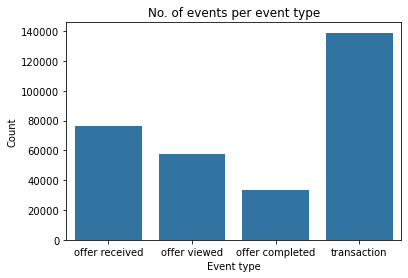

In [34]:
event_order = ['offer received', 'offer viewed', 'offer completed', 'transaction']
sb.countplot(data = transcript, x  = 'event', color = col, order = event_order)
plt.xlabel('Event type')
plt.ylabel('Count')
plt.title('No. of events per event type');

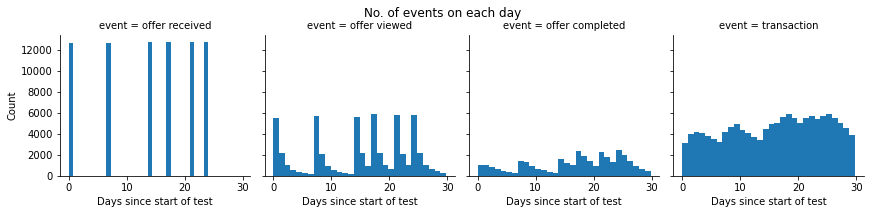

In [35]:
transcript['time_days'] = transcript.time/24
g = sb.FacetGrid(data = transcript, col = 'event', sharey = True, col_order = event_order)
g.map(plt.hist, 'time_days', bins = 30);
for i in range(len(event_order)):
    g.axes[0,i].set_xlabel('Days since start of test')
g.axes[0,0].set_ylabel('Count')
g.fig.subplots_adjust(top = 0.85)
g.fig.suptitle('No. of events on each day');

## Data preprocessing
Before starting with the prediction, the labels and features for the prediction have to be defined. The intention is to predict different offer outcomes (labels) with different characteristics of the offers and users (features).

### Labels: Offer outcomes
Depending on the combinations of receiving, viewing and completing offers, the outcomes are defined as follows:

|offer received|offer viewed|offer completed|offer outcome|
|:---:|:---:|:---:|:---:|
|1|1|1|success|
|1|0|1|waste|
|1|1|0|failure|
|1|0|0|failure|

The outcome labels are to be understood as follows:
- success: the offer had its intended effect
- waste: the offer was unnecessary because the effect was reached even though the user did not view the offer or viewed it after completing the offer
- failure: the offer did not have its intended effect regardless of being viewed or not

In [36]:
# get statistics for received offers
transcript.groupby('user_id').nunique().describe().offer_received

count    17000.000000
mean         3.722824
std          0.991758
min          0.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          6.000000
Name: offer_received, dtype: float64

In [37]:
# get dataframe with events connected to offers
offer_df = transcript[transcript.event != 'transaction']
# check how many people got offers
offer_df.user_id.nunique()

16994

The above cell shows that the total number of users is 17000, so all but 6 users got at least one offer. I will thus continue working with only the users that got at least one offer.

Next, a dataframe with the offer outcomes has to be created. This is achieved by iterating through each user and each offer sent to each offer. The ligic 

In [38]:
# get dataframe with events connected to offers
offer_df = transcript[transcript.event != 'transaction']
# initiate data frame
total_offers = len(offer_df.offer_received.dropna()) # total number of offers sent to users
outcome_df = pd.DataFrame(np.nan, index = np.arange(total_offers), 
                          columns = ['user_id', 'offer_id', 'offer_outcome'])
print('Total iterations:', total_offers) # for monitoring progress

start = time.time()
i = 0
for u_id in offer_df.user_id.unique(): # iterate through unique users 
    user_df = offer_df[offer_df.user_id == u_id] # get data frame for only one user
    for index, row in user_df.iterrows(): # iterate through received offers of this user
        if type(row.offer_received) is str: # if an offer was received
            outcome_df.loc[i,'user_id'] = u_id # write user id into data frame
            outcome_df.loc[i, 'offer_id'] = row.offer_received # write offer id into data frame
            
            rec_index = index # index of receiving
            # get views occuring after current offer
            views = user_df.loc[index+1:, 'offer_viewed'].str.match(row.offer_received).dropna()
            views = views.index[views]
            if views.empty: # in case offer was not viewed
                view_index = np.nan
            else: 
                view_index = views[0]
             
            # get completions occuring after current offer
            comps = user_df.loc[index+1:, 'offer_completed'].str.match(row.offer_received).dropna() 
            comps = comps.index[comps]
            if comps.empty: # in case offer was not completed
                comp_index = np.nan 
            else: 
                comp_index = comps[0]
            
            if (rec_index < view_index) & (view_index < comp_index): # offer received, viewed, completed
                outcome_df.loc[i, 'offer_outcome'] = 'success'
            if (rec_index < view_index) & np.isnan(comp_index): # offer received, viewed, not completed
                outcome_df.loc[i, 'offer_outcome'] = 'failure'
            if (rec_index < view_index) & (view_index > comp_index): # offer received, completed, viewed
                outcome_df.loc[i, 'offer_outcome'] = 'waste' 
            if np.isnan(view_index) & (rec_index < comp_index): # offer received, not viewed, completed
                outcome_df.loc[i, 'offer_outcome'] = 'waste'
            if np.isnan(view_index) & np.isnan(comp_index): # offer received, not viewed, not completed 
                outcome_df.loc[i, 'offer_outcome'] = 'failure'
                
            if i in np.arange(0, total_offers, 5000):
                print('Current iteration:', i) # monitor progress
            i += 1
            
            del [views, comps, rec_index, view_index, comp_index] # free memory
    del user_df # free memory
end = time.time()
print('Elapsed time:', (end-start)/60, 'minutes')

Total iterations: 76277
Current iteration: 0
Current iteration: 5000
Current iteration: 10000
Current iteration: 15000
Current iteration: 20000
Current iteration: 25000
Current iteration: 30000
Current iteration: 35000
Current iteration: 40000
Current iteration: 45000
Current iteration: 50000
Current iteration: 55000
Current iteration: 60000
Current iteration: 65000
Current iteration: 70000
Current iteration: 75000
Elapsed time: 25.672024019559224 minutes


In [39]:
# check for NAs
outcome_df.isna().sum()

user_id          0
offer_id         0
offer_outcome    0
dtype: int64

In [40]:
# get distribution of offer outcome
outcome_df.offer_outcome.value_counts()

failure    41352
success    24762
waste      10163
Name: offer_outcome, dtype: int64

In [41]:
# convert offer outcome to numeric
outcome_df.replace('success', 0, inplace = True)
outcome_df.replace('waste', 1, inplace = True)
outcome_df.replace('failure', 2, inplace = True)

### Features: Characteristics of offers and users
I chose to use the following characteristics as features for the prediction:
- Offers:
    - channel
    - offer type
    - difficulty
    - reward
    - offered before
- Users:
    - gender
    - age
    - income
    - membership duration
    
Almost all of these features are already present in the data, only the membership duration hast to be calculated.

In [42]:
# create feature for membership duration
profile['membership_duration'] = ((pd.to_datetime(date.today()) - profile.became_member_on)/np.timedelta64(1, 'D')).astype(int)

In [43]:
# convert gender to numeric
profile.replace('F', 0, inplace = True)
profile.replace('M', 1, inplace = True)
profile.replace('O', 2, inplace = True)

In [44]:
# convert offer types to numeric
portfolio.replace('bogo', 0, inplace = True)
portfolio.replace('informational', 1, inplace = True)
portfolio.replace('discount', 2, inplace = True)

In [45]:
# save portfolio data frame for further use
portfolio.to_csv('data/portfolio_features.csv', index = False)

### Merge labels and features

In [66]:
# merge all labels and features to one dataframe
features_labels = outcome_df.merge(profile[['user_id','gender', 'age', 'income', 'membership_duration']], 
                 how = 'inner', on = 'user_id')
features_labels = features_labels.merge(portfolio[['offer_id', 'email', 'mobile', 'social', 'web', 'difficulty', 'reward']], 
                 how = 'inner', on = 'offer_id')

In [47]:
features_labels.sample(10)

,user_id,offer_id,offer_outcome,gender,age,income,membership_duration,email,mobile,social,web,difficulty,reward
60679,7ede8e7cf9184907820365ce64bb8f7a,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,59,68000.0,1976,1,1,1,1,10,10
33707,fe0d05246e9040578a27cb39e23a1bdd,3f207df678b143eea3cee63160fa8bed,2,1,91,78000.0,2430,1,1,0,1,0,0
15115,a1c793fdc13b4cf1a69149b2d473be5a,ae264e3637204a6fb9bb56bc8210ddfd,2,1,29,31000.0,2087,1,1,1,0,10,10
30510,77cce09afacf466c84681f7cca06cf07,2906b810c7d4411798c6938adc9daaa5,2,1,57,31000.0,2320,1,1,0,1,10,2
17441,0a445954a2f749df8f0811d466dd31e0,ae264e3637204a6fb9bb56bc8210ddfd,0,1,25,72000.0,1249,1,1,1,0,10,10
38489,b427c95a76904412885fa43e1b6db748,3f207df678b143eea3cee63160fa8bed,2,0,45,99000.0,1826,1,1,0,1,0,0
48200,6d2db3aad94648259e539920fc2cf2a6,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,82,65000.0,1272,1,1,1,1,7,3
6412,1f9b1f3349f545eeb5dab2cb68e9a26e,9b98b8c7a33c4b65b9aebfe6a799e6d9,2,0,65,83000.0,1383,1,1,0,1,5,5
55626,9558179b943a42799dc4bd1465ef0f8c,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,37,61000.0,1461,1,0,0,1,20,5
2103,13f95724ed4042aaa8953e8ed5d073c9,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,18,43000.0,2171,1,1,0,1,5,5


## Prediction model

In [67]:
# split dataset into labels and features
X = features_labels.drop(['user_id', 'offer_id', 'offer_outcome'], axis = 1)
y = features_labels['offer_outcome']

In [68]:
# split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [69]:
start = time.time()

# create classifier using decision tree classification
clf = DecisionTreeClassifier() 

# define parameters for gridsearch
parameters = {'criterion':('gini', 'entropy'), 'min_samples_split':(2, 4),
             'min_samples_leaf':(1, 5, 10), 'max_features':(None, 'sqrt')}

# build parameter grid and fit data
cv_decision_tree = GridSearchCV(clf, parameters)
cv_decision_tree.fit(X_train, y_train)

# predict
y_pred = cv_decision_tree.predict(X_test)

end = time.time()
print('Elapsed time:', (end-start)/60, 'minutes')

Elapsed time: 0.25393060048421223 minutes


In [70]:
# evaluation
print('Chosen Parameters:', cv_decision_tree.best_params_)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred, average = 'weighted'))

Chosen Parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2}
Accuracy: 0.6482016119331168
f1 score: 0.6343321169645091


In [52]:
start = time.time()

# create classifier using naive bayes classification
clf = GaussianNB() 

# fit data
clf.fit(X_train, y_train)

# predict
y_pred = clf.predict(X_test)

end = time.time()
print('Elapsed time:', (end-start)/60, 'minutes')

Elapsed time: 0.0007591684659322103 minutes


In [53]:
# evaluation
print('Accuracy:', accuracy_score(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred, average = 'weighted'))

Accuracy: 0.6125947311439913
f1 score: 0.6024788749299966


In [54]:
start = time.time()

# create classifier using k-neighbors classification
clf = KNeighborsClassifier() 

# define parameters for gridsearch
parameters = {'weights':('uniform', 'distance'), 'p':(1, 2), 'leaf_size':(15, 30, 45)}

# build parameter grid and fit data
cv_k_neighbors = GridSearchCV(clf, parameters)
cv_k_neighbors.fit(X_train, y_train)

# predict
y_pred = cv_k_neighbors.predict(X_test)

end = time.time()
print('Elapsed time:', (end-start)/60, 'minutes')

Elapsed time: 0.6062112172444661 minutes


In [55]:
# evaluation
print('Chosen Parameters:', cv_k_neighbors.best_params_)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred, average = 'weighted'))

Chosen Parameters: {'leaf_size': 45, 'p': 1, 'weights': 'distance'}
Accuracy: 0.625586430891375
f1 score: 0.6224435837777094


In [56]:
start = time.time()

# create classifier using logistic regression 
clf = LogisticRegression(multi_class = 'multinomial') 

# define parameters for gridsearch
parameters = {'C':(.1, 1, 10), 'solver':('newton-cg', 'lbfgs', 'sag')}

# build parameter grid and fit data
cv_logistic_regression = GridSearchCV(clf, parameters)
cv_logistic_regression.fit(X_train, y_train)

# predict
y_pred = cv_logistic_regression.predict(X_test)

end = time.time()
print('Elapsed time:', (end-start)/60, 'minutes')

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn(

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch,

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not co

Elapsed time: 4.353418846925099 minutes


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


In [57]:
# evaluation
print('Chosen Parameters:', cv_logistic_regression.best_params_)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred, average = 'weighted'))

Chosen Parameters: {'C': 10, 'solver': 'newton-cg'}
Accuracy: 0.6201130759052087
f1 score: 0.5971174260550405


In [58]:
start = time.time()

# create classifier using random forest classification
clf = RandomForestClassifier() 

# define parameters for gridsearch
parameters = {'criterion':('gini', 'entropy'), 'min_samples_split':(2, 4),
             'min_samples_leaf':(1, 5, 10), 'max_features':(None, 'sqrt')}

# build parameter grid and fit data
cv_random_forest = GridSearchCV(clf, parameters)
cv_random_forest.fit(X_train, y_train)

# predict
y_pred = cv_random_forest.predict(X_test)

end = time.time()
print('Elapsed time:', (end-start)/60, 'minutes')

Elapsed time: 17.076120487848918 minutes


In [59]:
# evaluation
print('Chosen Parameters:', cv_random_forest.best_params_)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred, average = 'weighted'))

Chosen Parameters: {'criterion': 'entropy', 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 4}
Accuracy: 0.7010104655359076
f1 score: 0.6910445833124725


In [60]:
# save model
pickle.dump(cv_random_forest, open('outcome_prediction.pkl', 'wb'))